In [165]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.synthetic_generators import *
from generators.ESN import ESNGenerator
from sigkernel_.loss import compute_mmd_loss
from sigkernel_.kernels import gram
from utils.kernel_helpers import median_heuristic_sigma, tune_tau_coef_for_cv

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generator and ESN

In [ ]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 20  # number of samples
d = 1   # dimension of time series
p = 2   # AR order
q = 0   # MA order
phi = [0.7, -0.2] # AR coefficients
theta = None # MA coefficients

h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension (\xi : randomness), output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix
activation = "tanh"

# Define data generator and esn
target_generator = ARMA(T=T, p=p, q=q, phi=phi, theta=theta)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05, activation=activation)

# Generate examples

In [167]:
with torch.no_grad():
    X = target_generator.generate(N=N, noise=Noise("normal")).to(device=device, dtype=dtype)
    Z = esn(T=T, N=N).to(device=device, dtype=dtype)
print(f"Generated data shapes: X: {X.shape}, Z: {Z.shape}")

Generated data shapes: X: torch.Size([20, 200, 1]), Z: torch.Size([20, 200, 1])


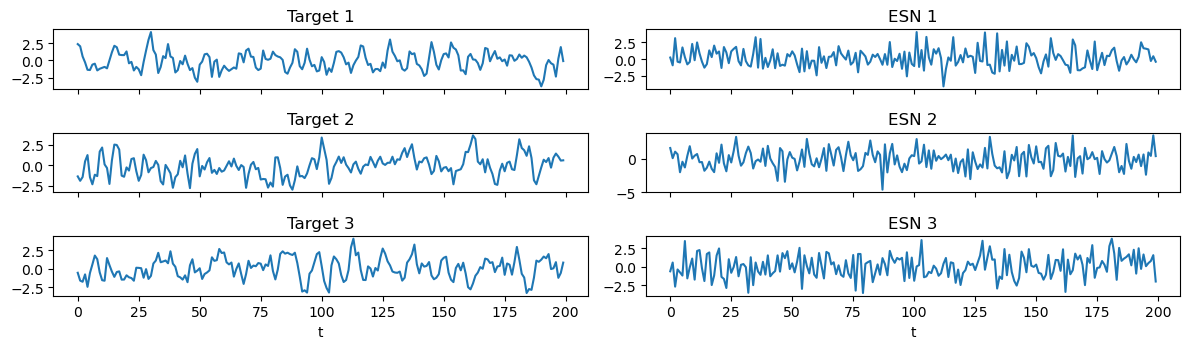

In [168]:
# visualize the current generators
n_examples = 3
fig, axes = plt.subplots(nrows=n_examples, ncols=2, figsize=(12, 1.2 * n_examples), sharex=True)
if n_examples == 1:
    axes = axes.reshape(1, 2)

for i in range(n_examples):
    axes[i, 0].plot(X[i, :, 0].numpy())
    axes[i, 0].set_title(f"Target {i+1}")
    axes[i, 1].plot(Z[i, :, 0].numpy())
    axes[i, 1].set_title(f"ESN {i+1}")
for ax in axes[-1, :]:
    ax.set_xlabel("t")
plt.tight_layout()
plt.show()

# Kernels

Given two sets of points $\{x_i\}_{i=1}^n$ and $\{y_j\}_{j=1}^m$, we compute the pairwise squared Euclidean distances
$$
d_{ij} = \lVert x_i - y_j \rVert^2, \qquad i = 1,\dots,n,\; j = 1,\dots,m.
$$

The median heuristic sets the kernel bandwidth according to
$$
\sigma^2 = \operatorname{median}\{ d_{ij} : 1 \le i \le n,\; 1 \le j \le m \},
$$
or, equivalently,
$$
\sigma = \sqrt{\operatorname{median}(d_{ij})}.
$$


In [169]:
median_heuristic_sigma_val = median_heuristic_sigma(X, Z)
print(f"Median heuristic sigma: {median_heuristic_sigma_val:.4f}")

# Define the discretized signature kernel (note that the median heuristic sigma doesn't work for rq)
static_kernel_type_disc    = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels              = 10 # number of levels in the truncated signature kernel
disc_sig_kernel_sigma = median_heuristic_sigma_val # bandwidth parameter for the static kernel

kwargs_disc_sig = {
    'static_kernel_type': static_kernel_type_disc,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs_disc_sig)

#---------------------------------
# Define the pde signature kernel
pde_sig_sigma = median_heuristic_sigma_val # bandwidth parameter for the static kernel
static_kernel_pde = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel_pde, dyadic_order=0)

#---------------------------------
# Define static kernel
static_sigma = median_heuristic_sigma_val
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

#---------------------------------
# Volterra kernel
ld_coef = 0.7
tau_best, cv_best, spec_best = tune_tau_coef_for_cv(X, ld_coef=ld_coef)
tau_coef = tau_best
volterra_kernel = ksig_disc.kernels.VolterraKernel(ld_coef=ld_coef, tau_coef=tau_coef)
volterra_kernel.fit(X) # fitting is needed to compute lambda, tau and the normalization constant
print(f"Best tau: {tau_best}, CV: {cv_best}")

Median heuristic sigma: 27.0543
Best tau: 0.7525, CV: 0.006464924664160763


# RBF

In [170]:
rbf_gram = gram(rbf_kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print("RBF Gram matrix stats:")
print(f"Shape: {rbf_gram.shape}")
print(f"Min: {rbf_gram.min().item():.4f}")
print(f"Max: {rbf_gram.max().item():.4f}")
print(f"Mean: {rbf_gram.mean().item():.4f}")
print(f"Std: {rbf_gram.std().item():.4f}")

print("First 3 rows and columns of RBF Gram matrix:")
print(rbf_gram[:3, :3])

RBF Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 0.2654
Max: 0.4761
Mean: 0.3704
Std: 0.0374
First 3 rows and columns of RBF Gram matrix:
tensor([[0.3791, 0.3404, 0.3282],
        [0.3716, 0.3316, 0.3316],
        [0.3121, 0.3300, 0.3036]], dtype=torch.float64)


In [171]:
mmd_rbf = compute_mmd_loss(rbf_kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print(f"MMD (RBF kernel): {mmd_rbf.item():.6f}")

MMD (RBF kernel): 0.000987


# SIG-PDE

In [172]:
sig_pde_gram = gram(sig_pde_kernel, X, Z)
print("sig_pde Gram matrix stats:")
print(f"Shape: {sig_pde_gram.shape}")
print(f"Min: {sig_pde_gram.min().item():.4f}")
print(f"Max: {sig_pde_gram.max().item():.4f}")
print(f"Mean: {sig_pde_gram.mean().item():.4f}")
print(f"Std: {sig_pde_gram.std().item():.4f}")

print("First 3 rows and columns of sig_pde Gram matrix:")
print(sig_pde_gram[:3, :3])

sig_pde Gram matrix stats:
Shape: torch.Size([20, 20])
Min: -0.0711
Max: 3.2686
Mean: 1.3468
Std: 0.3946
First 3 rows and columns of sig_pde Gram matrix:
tensor([[2.3328, 3.2686, 0.6001],
        [0.7692, 0.6766, 1.8659],
        [1.1237, 1.4374, 1.5301]], dtype=torch.float64)


In [173]:
mmd_sig_pde = compute_mmd_loss(sig_pde_kernel, X, Z)
print(f"MMD (sig_pde kernel): {mmd_sig_pde.item():.6f}")

MMD (sig_pde kernel): 2.102906


# SIG-DISC

In [174]:
sig_disc_gram = gram(sig_disc_kernel, X, Z)
print("sig_disc Gram matrix stats:")
print(f"Shape: {sig_disc_gram.shape}")
print(f"Min: {sig_disc_gram.min().item():.4f}")
print(f"Max: {sig_disc_gram.max().item():.4f}")
print(f"Mean: {sig_disc_gram.mean().item():.4f}")
print(f"Std: {sig_disc_gram.std().item():.4f}")

print("First 3 rows and columns of sig_disc Gram matrix:")
print(sig_disc_gram[:3, :3])

sig_disc Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 1.0510
Max: 1.1492
Mean: 1.1088
Std: 0.0182
First 3 rows and columns of sig_disc Gram matrix:
tensor([[1.1208, 1.1311, 1.1339],
        [1.1258, 1.1329, 1.1352],
        [1.1233, 1.1305, 1.1329]], dtype=torch.float64)


In [175]:
mmd_sig_disc = compute_mmd_loss(sig_disc_kernel, X, Z)
print(f"MMD (sig_disc kernel): {mmd_sig_disc.item():.6f}")

MMD (sig_disc kernel): 0.212070


# Volterra

In [176]:
volterra_gram = gram(volterra_kernel, X, Z)
print("Volterra Gram matrix stats:")
print(f"Shape: {volterra_gram.shape}")
print(f"Min: {volterra_gram.min().item():.4f}")
print(f"Max: {volterra_gram.max().item():.4f}")
print(f"Mean: {volterra_gram.mean().item():.4f}")
print(f"Std: {volterra_gram.std().item():.4f}")

print("First 3 rows and columns of Volterra Gram matrix:")
print(volterra_gram[:3, :3])

Volterra Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 1.3550
Max: 1.4337
Mean: 1.3840
Std: 0.0091
First 3 rows and columns of Volterra Gram matrix:
tensor([[1.3857, 1.4003, 1.3922],
        [1.3833, 1.3909, 1.3779],
        [1.3818, 1.3826, 1.3701]], dtype=torch.float64)


In [177]:
mmd_volterra = compute_mmd_loss(volterra_kernel, X, Z)
print(f"MMD (volterra kernel): {mmd_volterra.item():.6f}")

MMD (volterra kernel): 0.001380


In [178]:
volterra_kernel.spec()

{'kernel_mode': 'sequential',
 'kernel_name': 'VolterraKernel',
 'kernel_params': {'tau_coef': 0.7525,
  'ld_coef': 0.8,
  'eps': 1e-12,
  'M': 5.352287292480469,
  'tau': 0.14059409722964641,
  'ld': 0.5268737989310155,
  'Gram0': 1.384266975265918},
 'kernel_str': 'VolterraKernel(tau=0.141, ld=0.527, M=5.35)'}

Verify that the torch implementation works as intended

In [180]:
import numpy as np
import torch

def volt_terminal_py(x, y, tau, ld, Gram0):
    # x,y: (T,d) numpy
    T = x.shape[0]
    G = np.zeros((T, T), dtype=np.float64)
    for i in range(T):
        for j in range(T):
            denom = 1.0 - (tau**2) * float(np.dot(x[i], y[j]))
            prev = Gram0 if (i == 0 or j == 0) else G[i-1, j-1]
            G[i, j] = 1.0 + (ld**2) * prev / denom
    return G[T-1, T-1]

# small random test
torch.manual_seed(0)
X = torch.randn(3, 6, 2, dtype=torch.float64)
Y = torch.randn(4, 6, 2, dtype=torch.float64)

ker = ksig_disc.kernels.VolterraKernel(tau_coef=0.5, ld_coef=0.7, eps=0.0).fit(X)  # eps=0 to match njit
K_torch = ker.compute_Gram(X, Y).cpu().numpy()

tau, ld, Gram0 = ker.tau, ker.ld, ker.Gram0
K_py = np.zeros((X.shape[0], Y.shape[0]))
for a in range(X.shape[0]):
    for b in range(Y.shape[0]):
        K_py[a,b] = volt_terminal_py(X[a].cpu().numpy(), Y[b].cpu().numpy(), tau, ld, Gram0)

print("max abs diff:", np.max(np.abs(K_torch - K_py)))


max abs diff: 0.0
